# Untitled Notebook

What's this notebook about?

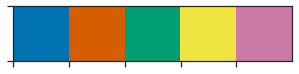

In [2]:
import re
import html
import sys
import os
from glob import glob
import random
from collections import Counter, defaultdict
import itertools as it

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [144]:
def get_gtf_attribute(gtf_record, attribute):
    try:
        attr = re.search(f'{attribute} "(.+?)";', gtf_record[8]).group(1)
    except AttributeError:
        raise ValueError(
            f'Could not parse attribute {attribute} '
            f'from GTF with feature type {record[2]}'
        )
    return attr


locus2gene = defaultdict(set)
with open('../../nanopore_apa_pipeline/pipeline/assembly/merged_nanopore_assembly.gtf') as gtf:
    for record in gtf:
        record = record.split('\t')
        if record[2] == 'transcript':
            locus_id = get_gtf_attribute(record, 'locus')
            gene_id = get_gtf_attribute(record, 'gene_id')
            if re.match('AT[1-5MC]G\d{5}', gene_id):
                locus2gene[locus_id].add(gene_id)

locus2gene = {k: ','.join(v) for k, v in locus2gene.items()}

In [171]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'cpm', 'logfc', 'pval', 'fdr', 'gene_level_fdr'
]

fpa_vs_col0 = pd.read_csv(
    '../pipeline/differential_expression/dexseq/fpa8_vs_col0.tsv',
    sep='\t',
    names=RESULTS_COLUMNS
)
fpa_vs_col0['gene_ids'] = fpa_vs_col0.locus_id.map(locus2gene)
fpa_vs_col0['abs_logfc'] = fpa_vs_col0.logfc.abs()

FPAox_vs_col0 = pd.read_csv(
    '../pipeline/differential_expression/dexseq/35SFPA_vs_col0.tsv',
    sep='\t',
    names=RESULTS_COLUMNS
)
FPAox_vs_col0['gene_ids'] = FPAox_vs_col0.locus_id.map(locus2gene)
FPAox_vs_col0['abs_logfc'] = FPAox_vs_col0.logfc.abs()

FPAox_vs_col0.head()

,chrom,start,end,locus_id,score,strand,cpm,logfc,pval,fdr,gene_level_fdr,gene_ids,abs_logfc
0,1,3683,3913,RLOC_00000001,.,+,23.71,0.5342,0.20690,0.3512,0.4395,NaN,0.5342
1,1,3995,4276,RLOC_00000001,.,+,34.32,0.3052,0.19040,0.3318,0.4395,NaN,0.3052
2,1,4485,4605,RLOC_00000001,.,+,23.45,0.3525,0.31410,0.4682,0.4395,NaN,0.3525
3,1,4705,5095,RLOC_00000001,.,+,48.99,-0.0682,0.57110,0.7014,0.4395,NaN,0.0682
4,1,5173,5326,RLOC_00000001,.,+,36.48,-0.3185,0.05584,0.1443,0.4395,NaN,0.3185


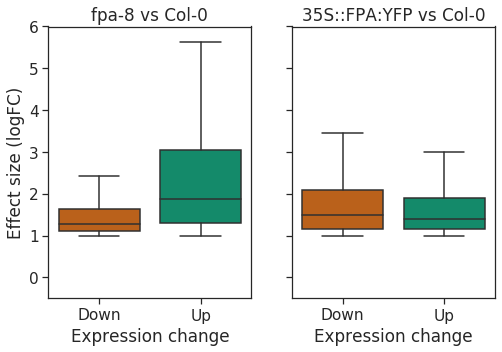

In [119]:
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

fpa_sig = fpa_vs_col0.query('fdr < 0.05 & gene_level_fdr < 0.05 & abs_logfc > 1')
FPAox_sig = FPAox_vs_col0.query('fdr < 0.05 & gene_level_fdr < 0.05 & abs_logfc > 1')

sns.boxplot(
    x=fpa_sig.logfc > 0,
    y=fpa_vs_col0.logfc.abs(),
    ax=axes[0],
    palette=pal[1:3],
    fliersize=0
)

sns.boxplot(
    x=FPAox_sig.logfc > 0,
    y=FPAox_vs_col0.logfc.abs(),
    ax=axes[1],
    palette=pal[1:3],
    fliersize=0
)

axes[0].set_title('fpa-8 vs Col-0')
axes[1].set_title('35S::FPA:YFP vs Col-0')
axes[0].set_ylim(-0.5, 6)
axes[0].set_ylabel('Effect size (logFC)')
axes[1].set_ylabel('')
axes[0].set_xticklabels(['Down', 'Up'])
axes[1].set_xticklabels(['Down', 'Up'])
axes[0].set_xlabel('Expression change')
axes[1].set_xlabel('Expression change')
plt.show()

In [224]:
genes_tested_in_both = set(fpa_vs_col0.locus_id).intersection(FPAox_vs_col0.locus_id)

fpa_sig_genes = set(fpa_sig.locus_id)
FPAox_sig_genes = set(FPAox_sig.locus_id)

print(
    len(fpa_sig_genes.intersection(FPAox_sig_genes)) - 1,
    len(genes_tested_in_both),
    len(fpa_sig_genes.intersection(genes_tested_in_both)),
    len(FPAox_sig_genes.intersection(genes_tested_in_both)),
)

stats.hypergeom.sf(
    len(fpa_sig_genes.intersection(FPAox_sig_genes)) - 1,
    len(genes_tested_in_both),
    len(fpa_sig_genes.intersection(genes_tested_in_both)),
    len(FPAox_sig_genes.intersection(genes_tested_in_both)),
)

858 15693 2481 1733


1.972982883068597e-277

In [229]:
fpa_vs_col0[fpa_vs_col0.locus_id == 'RLOC_00032138']

,chrom,start,end,locus_id,score,strand,cpm,logfc,pval,fdr,gene_level_fdr,gene_ids,abs_logfc
113377,5,17522537,17522987,RLOC_00032138,.,+,78.21,-1.4609,1.207000e-08,9.645000e-07,0.000002,NaN,1.4609
113378,5,17522987,17523302,RLOC_00032138,.,+,28.00,0.7127,2.775000e-05,7.036000e-04,0.000002,NaN,0.7127
113379,5,17523302,17523436,RLOC_00032138,.,+,17.23,-0.3390,7.296000e-01,8.173000e-01,0.000002,NaN,0.3390
113380,5,17523436,17523755,RLOC_00032138,.,+,44.08,0.8793,1.946000e-05,5.412000e-04,0.000002,NaN,0.8793
113381,5,17523755,17523814,RLOC_00032138,.,+,19.94,0.6567,5.480000e-03,2.773000e-02,0.000002,NaN,0.6567
113382,5,17523814,17523987,RLOC_00032138,.,+,17.49,-0.0695,2.277000e-01,3.645000e-01,0.000002,NaN,0.0695


In [203]:
tair10_annot = []

with open('/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.gff') as gff:
    for record in gff:
        if record.startswith('#'):
            continue
        record = record.strip().split('\t')
        if record[2] == 'gene':
            attr = record[8]
            attr = attr.split(';')
            attr_dict = {}
            for a in attr:
                k, v = a.split('=')
                attr_dict[k] = v
            tair10_annot.append(attr_dict)

tair10_annot = pd.DataFrame(tair10_annot)
tair10_annot = tair10_annot[['ID', 'symbol', 'Alias', 'full_name', 'Note', 'locus_type', 'curator_summary']]
tair10_annot.columns = ['gene_id', 'gene_symbol', 'aliases', 'gene_name', 'gene_description', 'gene_biotype', 'curator_summary']
tair10_annot = tair10_annot.set_index('gene_id')
tair10_annot.head()

,gene_symbol,aliases,gene_name,gene_description,gene_biotype,curator_summary
gene_id,,,,,,
AT1G01010,NAC001,"ANAC001,NAC domain containing protein 1",NAC domain containing protein 1,NAC domain containing protein 1,protein_coding,NaN
AT1G01020,ARV1,NaN,NaN,ARV1 family protein,protein_coding,NaN
AT1G03987,NaN,NaN,NaN,NaN,long_noncoding_rna,NaN
AT1G01030,NGA3,NaN,NGATHA3,AP2/B3-like transcriptional factor family protein,protein_coding,NaN
AT1G01040,DCL1,"ASU1,ABNORMAL SUSPENSOR 1,ATDCL1,DICER-LIKE 1,...",dicer-like 1,dicer-like 1,protein_coding,Encodes a Dicer homolog. Dicer is a RNA helica...


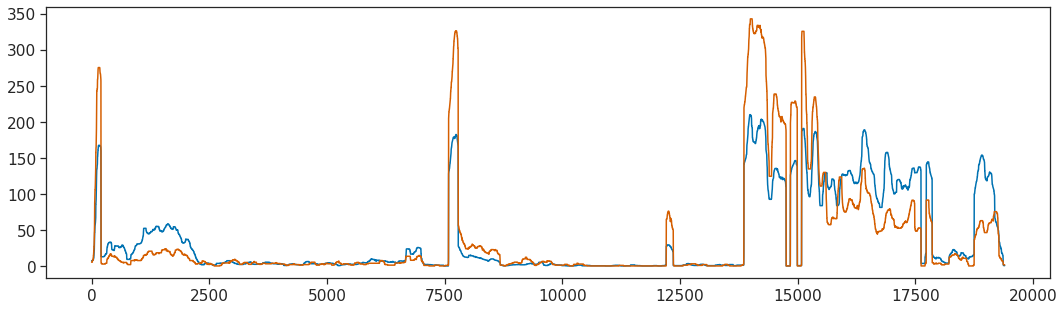

In [34]:
import pyBigWig as pybw
import scipy.ndimage as ndi

def read_bw(bw_fn, chrom, start, end):
    bw = pybw.open(bw_fn)
    vals = bw.values(chrom, start, end, numpy=True)
    vals[np.isnan(vals)] = 0
    return vals

def norm_factors(profiles):
    p = np.sum(profiles, axis=1)
    n = p.mean()
    return n / p


def normalise_profiles(cntrl_arrs, treat_arrs):
    prof = np.concatenate([cntrl_arrs, treat_arrs])
    n = norm_factors(prof)
    prof = (prof.T * n).T
    prof[np.isnan(prof)] = 0
    return prof[:len(cntrl_arrs)], prof[len(cntrl_arrs):]


def median_filter_second_axis(profiles, size):
    return np.asarray([
        ndi.median_filter(p, size=size, mode='nearest')
        for p in profiles
    ])


mock = [read_bw(fn, '1', 21746300, 21765700)
        for fn in glob('/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/upf1upf3_rnaseq/coverage_tracks/col0mock_*.bw')]
mock = np.array(mock)

chx = [read_bw(fn, '1', 21746300, 21765700)
       for fn in glob('/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/upf1upf3_rnaseq/coverage_tracks/col0chx_*.bw')]
chx = np.array(chx)

mock, chx = normalise_profiles(mock, chx)
mock = median_filter_second_axis(mock, 101)
chx = median_filter_second_axis(chx, 101)

fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(np.median(mock, axis=0), color=pal[0])
ax.plot(np.median(chx, axis=0), color=pal[1])
plt.show()

In [44]:
fns = glob('/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/hpa_rnaseq/unpooled_data/*.fastq.gz')
sample_names = [re.search('unpooled_data/(.+\-\d+ddpi_\d)', f).group(1) for f in fns]
for fn, sn in zip(fns, sample_names):
    o = f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/hpa_rnaseq/raw_data/{sn}.fastq.gz'
    !cat {fn} >> {o}